# Empirical validation of property 1

This notebook is dedicated to an empirical validation of the following property from the MAD paper:

Property 1

Let $X \in R^{n \times T \times q}$ and $X^\prime \in R^{n^\prime \times T^\prime \times q}$ be time series datasets.
Let $\text{OT}_\text{DTW}(X, X^\prime)$ be the solution of the OT problem with cost $\mathbf{C}(X, X^\prime) = \{\text{DTW}(x,x^\prime)\}_{x,x^\prime \in X, X^\prime}$, and let us denote $\text{cost}(\cdot)$ the cost associated to a solution of any optimization problem.

We have:


$\text{cost}\Big(\text{OT}_\text{DTW}(X, X^\prime)\Big) \leq \text{cost}\Big((|\mathcal{C}|\text{-MAD}(X, X^\prime, Y)\Big)$


$\text{cost}\Big(|\mathcal{C}|\text{-MAD}(X, X^\prime, Y)\Big) \leq \text{cost}\Big(\text{MAD}(X, X^\prime)\Big)$

Empirical proof:

We compare, over several repetitions on random datasets, the respective costs of $\text{OT}_\text{DTW}(X, X^\prime)$, $|\mathcal{C}|$-MAD and MAD.

Please note that due to the local convergence of the optimization, the property might not hold on obtained solutions at each run (though it holds on optimal solutions).

In [1]:
import numpy.random as npr
import numpy as np
import ot
import tslearn.metrics as tslm
import matplotlib.pyplot as plt


2023-03-31 14:11:39.016634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Numpy version of the MAD algorithm

In [2]:
# The MAD algorithm

class MAD:
    def __init__(self, X, Y, classe=None):

        self.X = X
        self.Y = Y
        self.shapeX = X.shape
        self.shapeY = Y.shape
        if classe is not None:
            classe = classe.astype(int)
            cl_count = 0
            classe_corrected = np.empty((self.shapeX[0], 1), dtype=int)
            for cl in np.unique(classe):
                classe_corrected[np.where(classe == cl)] = cl_count
                cl_count = cl_count + 1
            self.classe = classe_corrected
        else:
            self.classe = np.zeros((self.shapeX[0], 1), dtype=int)
        self.shapeX = X.shape
        self.shapeY = Y.shape
        self.classe_unique = np.unique(self.classe)
        self.one_dim = False
        self.Xa_one = np.ones(self.shapeX[0]) / self.shapeX[0]
        self.Ya_one = np.ones(self.shapeY[0]) / self.shapeY[0]
        self.OT_tilde = self.init_OT_matrix()

        self.tab_idx = []
        self.dist_OT = []
        self.pi_DTW_idx = []
        self.pi_DTW_path_idx = []
        self.Xsquared = []
        self.Xsquared_sum = []
        self.Ysquared = self.Y ** 2
        for cl in self.classe_unique:
            self.tab_idx.append(np.where(self.classe == cl)[0])
            self.pi_DTW_idx.append(self.init_DTW_matrix())
            X2 = self.X[self.tab_idx[cl]] ** 2
            X2_sum = np.dot(self.Xa_one[self.tab_idx[cl]], X2.transpose(1, 0, -1)).sum(-1)
            self.Xsquared.append(X2)
            self.Xsquared_sum.append(X2_sum[:, None])


    def init_OT_matrix(self):
        cost_OT = np.ones((self.shapeX[0], self.shapeY[0]))
        OT_tilde = ot.emd(self.Xa_one, self.Ya_one, cost_OT, numItermax=10000000)
        return OT_tilde

    def init_DTW_matrix(self):
        DTW_matrix = np.zeros((self.shapeX[1], self.shapeY[1]))
        ts = [0, 0]
        indices_table = [[1, 0], [0, 1], [1, 1]]
        while (ts[0] != self.shapeX[1] - 1) or (ts[1] != self.shapeY[1] - 1):
            DTW_matrix[ts[0], ts[1]] = 1
            if ts[0] == self.shapeX[1] - 1:
                indice_moving = 1
            elif ts[1] == self.shapeY[1] - 1:
                indice_moving = 0
            else:
                indice_moving = npr.randint(3)
            ts[0] = ts[0] + indices_table[indice_moving][0]
            ts[1] = ts[1] + indices_table[indice_moving][1]
        DTW_matrix[-1, -1] = 1
        return DTW_matrix

    def mat_cost_OT(self):
        mat_cost = np.zeros(shape=(self.shapeX[0], self.shapeY[0]))

        for cl in self.classe_unique:
            pi_DTW = self.pi_DTW_idx[cl]
            C1 = np.dot(self.Xsquared[cl].transpose(0, -1, 1), np.sum(pi_DTW, axis=1)).sum(-1)
            C2 = np.dot(self.Ysquared.transpose(0, -1, 1), np.sum(pi_DTW.T, axis=1)).sum(-1)
            C3 = np.tensordot(np.dot(self.X[self.tab_idx[cl]].transpose(0, -1, 1), pi_DTW), self.Y,
                                axes=([1, 2], [2, 1]))
            res = C1[:, None] + C2[None, :] - 2 * C3
            mat_cost[self.tab_idx[cl]] = res
        mat_cost /= (self.shapeX[1] + self.shapeY[1]) / 2
        return mat_cost

    def mat_dist_DTW(self, classe_it=None):
        if classe_it is None:
            OTc = self.OT_tilde
            Xc = self.X
        else:
            OTc = self.OT_tilde[self.tab_idx[classe_it]]
            Xc = self.X[self.tab_idx[classe_it]]
        C2 = np.dot(OTc.sum(axis=0), self.Ysquared.transpose(1, 0, -1)).sum(-1)
        C31 = np.dot(Xc.T, OTc)
        C32 = np.tensordot(C31, self.Y, axes=([0, 2], [2, 0]))
        res = self.Xsquared_sum[classe_it] + C2[None, :] - 2 * C32
        res /= (self.shapeX[1] + self.shapeY[1]) / 2
        return res

    def path2mat(self, path):
        pi_DTW = np.zeros((self.shapeX[1], self.shapeY[1]))
        for i, j in path:
            pi_DTW[i, j] = 1
        return pi_DTW

    def stopping_criterion(self, last_pi_DTW):
        stop = True
        for cl in self.classe_unique:
            pi_DTW = self.pi_DTW_idx[cl]
            last_DTW = last_pi_DTW[cl]
            if (pi_DTW != last_DTW).any():
                stop = False
        return stop

    def main_training(self, max_iter=1000, first_step_DTW=True):
        stop = False
        current_init = 0
        while stop is not True and current_init < max_iter:
            if (current_init != 0) or (first_step_DTW is False):
                Cost_OT = self.mat_cost_OT()
                self.OT_tilde = ot.emd(self.Xa_one, self.Ya_one, Cost_OT, numItermax=1000000)
                score_OT = np.sum(self.OT_tilde * Cost_OT)

            dtw_score = 0
            self.pi_DTW_path_idx = []
            total_cost_DTW = []
            for cl in self.classe_unique:
                mat_dist = self.mat_dist_DTW(cl)
                total_cost_DTW.append(mat_dist)
                Pi_DTW_path, dtw_score_prov = tslm.dtw_path_from_metric(mat_dist, metric="precomputed")
                self.pi_DTW_path_idx.append(Pi_DTW_path)
                Pi_DTW_prov = self.path2mat(Pi_DTW_path)
                self.pi_DTW_idx[cl] = Pi_DTW_prov
                dtw_score += dtw_score_prov
            if current_init != 0:
                stop = self.stopping_criterion(last_pi_DTW)
            last_pi_DTW = self.pi_DTW_idx.copy()
            current_init = current_init + 1
        else:
            return self.OT_tilde, self.pi_DTW_idx, Cost_OT, score_OT



$OT_{DTW}$ functions : computing the cost for DTW and solving it

In [3]:

def dtw(x, y):
    l1 = x.shape[0]
    l2 = y.shape[0]
    cum_sum = np.full((l1 + 1, l2 + 1), np.inf)
    cum_sum[0, 0] = 0.
    for i in range(l1):
        for j in range(l2):
            cum_sum[i + 1, j + 1] = ((x[i] - y[j]) ** 2).sum()
            cum_sum[i + 1, j + 1] += min(cum_sum[i, j + 1], cum_sum[i + 1, j], cum_sum[i, j])
    return cum_sum[-1, -1]

def dtw_cost(X, Y):
    cost = np.zeros(shape=(X.shape[0], Y.shape[0]))
    for s in range(0, X.shape[0]):
        for t in range(0, Y.shape[0]):
            score_dtw = dtw(X[s], Y[t])
            cost[s, t] = score_dtw
    cost /= (X.shape[1] + Y.shape[1]) / 2
    return cost


We generate random datasets and compare the different costs associated with MAD, $|\mathcal{C}|$-MAD and $OT_{DTW}$. As computation time might be long for $OT_{DTW}$ there is currently only 10 repetitions on smaller datasets than the ones in the paper, but feel free to increase these numbers.

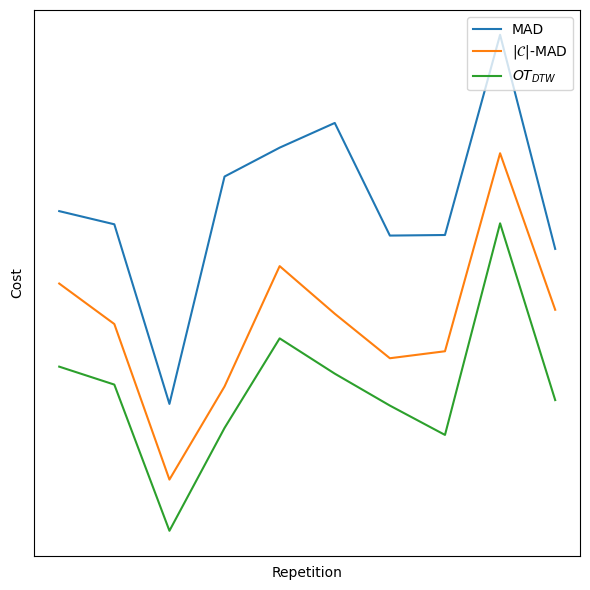

In [4]:
deepjdot_costs = []
c_mad_costs = []
mad_costs = []

npr.seed(10)
different_than_expected = 0
for n in range(0, 10):
    nb_class = 5
    nb_series = 20
    nb_times = 5
    nb_feature = 2
    data_X = npr.normal(size=(nb_series, nb_times, nb_feature))
    data_Y = npr.normal(size=(nb_series, nb_times, nb_feature))
    class_x = np.zeros(shape=(nb_series))
    num_class = int(nb_series/nb_class)
    for i in range(1, nb_class):
        class_x[i * num_class:(i + 1) * num_class] = i
        data_X[class_x == 1, 2 * i:] = data_X[class_x == 1, 2 * i:] + i
        data_Y[class_x == 1, i:] = data_Y[class_x == 1, i:] + i

    mad = MAD(data_X, data_Y)
    OT, _, _, score = mad.main_training()
    mad_costs.append(score)
    c_mad = MAD(data_X, data_Y, class_x)
    OT_class, _, _, score_class = c_mad.main_training()
    c_mad_costs.append(score_class)

    a = np.ones(shape=(nb_series,)) / nb_series
    b = np.ones(shape=(nb_series,)) / nb_series
    cost = dtw_cost(data_X, data_Y)
    OT_DTW = ot.emd(a, b, cost)
    score_ot_dtw = np.sum(cost * OT_DTW)
    deepjdot_costs.append(score_ot_dtw)

plt.figure(figsize=(6, 6))
plt.plot(mad_costs, label="MAD")
plt.plot(c_mad_costs, label="$|\mathcal{C}|$-MAD")
plt.plot(deepjdot_costs, label="$OT_{DTW}$")
plt.ylabel('Cost')
plt.xlabel("Repetition")
plt.xticks([])
plt.yticks([])
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
